$$\underline{\text{Projet 1 : Estimation de densité}}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

$$\underline{{\text{Exercice 1}}}$$

1)

a) Nous allons générer un vecteur aléatoire, de 50 élements, suivant chacun une loi normale de moyenne -1.5 et de variance 2.
Nous utlisons la fonction random.normal du package Numpy :

In [3]:
nNorm = 50
mNorm = -1.5
sigNorm = 2
N = np.random.normal(mNorm, sigNorm, nNorm)

Voici l'histogramme du vecteur généré :

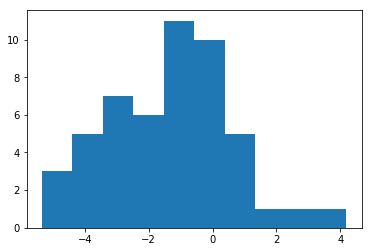

In [4]:
plt.hist(N)
plt.show()

b) Nous allons maintenant générer un vecteur aléatoire de 50 élements, suivant chacun une loi uniforme entre 0 et 1.
Nous utilisons la fonction random.uniform du package Numpy :

In [5]:
nUnif = 50
minUnif = 0
maxUnif = 1
U = np.random.uniform(minUnif, maxUnif, nUnif)

Voici l'histogramme du vecteur généré :

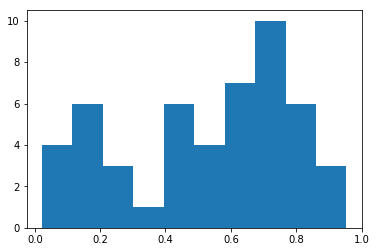

In [6]:
plt.hist(U)
plt.show()

c) Enfin, nous concatenons les deux vecteurs aléatoires générés en a) et b), afin d'obtenir un vecteur de 100 élements, les 50 premiers étants les élements de N et les 50 suivants étant les élements de U.

In [8]:
X = np.concatenate([N, U])

On obtient ainsi un vecteur de taille 100, noté X, dont les élements Xi sont considérés comme étant iid.

2)

a) Voici l'histogramme du vecteur crée en 1)c), construit avec la fonction hist du module matplotlib.pyplot : 

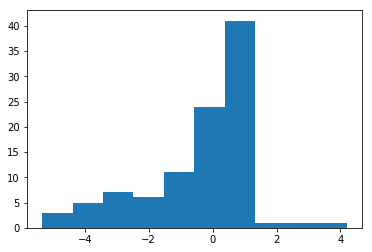

In [9]:
plt.hist(X)
plt.show()

b) Nous allons maintenant estimer la densité de probabilité du vecteur aléatoire X, puis la tracer sur un graphique, grâce à la méthode du noyau.
Pour rappel, l'estimateur de la densité par la méthode du noyau est le suivant :
$$\hat{f}(x) = \frac{1}{nh} \sum_{i=1}^{n} K(\frac{X_i - x}{h})$$

Nous utiliserons pour cela les 3 noyaux de base : 
 * Noyau Rectangulaire : $$K(x) = \frac{1}{2} \mathbb{1}({x \in [-1, 1]})$$
 * Noyau Triangulaire : $$K(x) = (1 - |x|) \mathbb{1}({x \in [-1, 1]})$$
 * Noyaux Gaussien : $$K(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$$

Enfin, on choisis la fenêtre de lissage h, à défaut d'une optimisation numérique, graphiquement, de manière grossière (à l'oeil)

In [10]:
def kernel_density_plot(X, h, kernel=None):
    f = list()
    n = X.size
    
    for n_grill in np.linspace(min(X), max(X)):
        f_tmp = 0.0
        for Xj in X:
            if kernel == "rectangular" or kernel == None:
                f_tmp = f_tmp + 1.0/(n*h) * 1.0/2.0 * (Xj >= (n_grill - h) and Xj <= (n_grill + h))
            elif kernel == "triangular":
                f_tmp = f_tmp + 1.0/(n*h) * (1-abs((Xj-n_grill)/h)) * (Xj >= (n_grill - h) and Xj <= (n_grill + h))                
            elif kernel == "gaussian":
                f_tmp = f_tmp + 1.0/(n*h) * 1/(np.sqrt(2*np.pi)) * np.exp(-np.power(((Xj - n_grill)/h)/2, 2))
            else:
                f_tmp = f_tmp + 1.0/(n*h) * 1.0/2.0 * (Xj >= (n_grill - h) and Xj <= (n_grill + h))
        f.append(f_tmp)
    
    plt.plot(f)
    plt.show()

b1) Noyau Rectangulaire

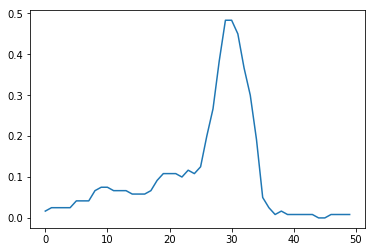

In [11]:
kernel_density_plot(X, 0.6, "rectangular")

b2) Noyau Triangulaire

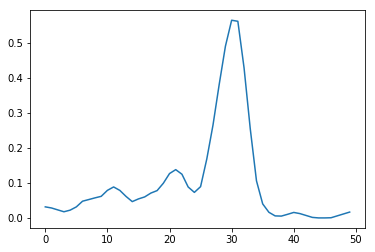

In [12]:
kernel_density_plot(X, 0.6, "triangular")

b3) Noyau Gaussien

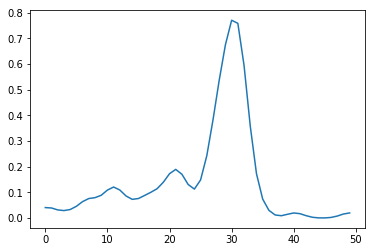

In [13]:
kernel_density_plot(X, 0.2, "gaussian")

c) Nous allons maintenant estimer la densité du vecteur aléatoire X par la méthode de la validation croisée
$$$$
L'estimateur de validation croisée est un estimateur dont la fenêtre de lissage h, est optimisé préalablement à l'estimation de la densité :
$$\hat{f}^{CV}(x) = \frac{1}{nh^{CV}} \sum_{i=1}^{n} K(\frac{X_i - x}{h^{CV}})$$
$$\text{avec } h^{CV} = argmin(\hat{CV}(h))$$
$$\text{où } \hat{CV}(h) = \int_{-\infty}^{+\infty}\hat{f}^2(x)dx - 2\hat{G}(h)$$
$$\text{et } \hat{G}(h) = \frac{1}{n} \sum_{j=1}^{n} \frac{1}{(n-1)h} \sum_{i \neq j}^{n} K(\frac{X_j - X_i}{h})$$
$$$$
Ainsi, on construit :
 * Une fonction integral, qui permet d'estimer l'intégrale d'une fonction par la méthodes des rectangles
 * une fonction G, décrite ci-dessus
 * une fonction CV, décrite ci-dessus
$$$$
Nous allons ensuite, de manière itérative, trouver la fenêtre de lissage h qui minimise la valeur de CV.
On insère ensuite ce h optimal dans notre estimateur classique à noyau, obtenant ainsi l'estimateur de la densité par validation croisée

In [14]:
def integral(f, a, b, **f_kwargs):
    n = 1000
    S = 0
    for i_x in range(0, n):
        xi = a + (b - a) * i_x / float(n)
        xj = a + (b - a) * (i_x + 1) / float(n)
        
        S = S + f(x=(xi + xj)/2.0, **f_kwargs) * (xj - xi)
    return S

In [15]:
def Gh(X=None, h=None, kernel=None):
    n = X.size
    gh = 0
    for j_row, Xj in enumerate(X):
        f_moins_i = 0
        for i_row, Xi in enumerate(X):
            if i_row != j_row: 
                if kernel == "rectangular" or kernel == None:
                    f_moins_i = f_moins_i + \
                        1.0/((n-1)*h) * 1.0/2.0 * (Xi >= (Xj - h) and Xi <= (Xj + h))
                elif kernel == "triangular":
                    f_moins_i = f_moins_i + \
                        1.0/((n-1)*h) * (1-abs((Xi-Xj)/h)) * \
                        (Xi >= (Xj - h) and Xi <= (Xj + h))
                elif kernel == "gaussian":
                    f_moins_i = f_moins_i + \
                        1.0/((n-1)*h) * 1/(np.sqrt(2*np.pi)) * \
                        np.exp(-np.power(((Xi - Xj)/h)/2, 2))
                else:
                    f_moins_i = f_moins_i + \
                        1.0/((n-1)*h) * 1.0/2.0 * (Xi >= (Xj - h) and Xi <= (Xj + h))  
        f_moins_i = 1.00/n * f_moins_i
        gh = gh + f_moins_i
    
    return gh

In [20]:
def kernel_density(X=None, x=None, h=None, kernel=None):
    n = X.size
    f_chap = 0.0
    
    if kernel == 'rectangular' or kernel == None:
        for Xj in X:
            f_chap = f_chap + \
                1.0/(n*h) * 1.0/2.0 * \
                (Xj >= (x - h) and Xj <= (x + h))
    elif kernel == 'triangular': 
        for Xj in X:
            f_chap = f_chap + \
                1.0/(n*h) * (1-abs((Xj-x)/h)) * \
                (Xj >= (x - h) and Xj <= (x + h))
    elif kernel == 'gaussian': 
        for Xj in X:
            f_chap = f_chap + \
                1.0/(n*h) * 1/(np.sqrt(2*np.pi)) * \
                np.exp(-np.power(((Xj - x)/h)/2, 2))
    else:
        for Xj in X:
            f_chap = f_chap + \
                1.0/(n*h) * 1.0/2.0 * \
                (Xj >= (x - h) and Xj <= (x + h))
        
    return f_chap

In [16]:
def squared_kernel_density(X=None, x=None, h=None, kernel=None):
    
    kdens = kernel_density(X, x, h, kernel)
    
    return np.power(kdens, 2)

In [17]:
def CV(X, h, kernel_method):
    
    cv = integral(squared_kernel_density, min(X), max(X), X=X, h=h, kernel=kernel_method) - \
        2 * Gh(X, h, kernel_method)
        
    return cv 

In [18]:
def h_opt(X):
    h_opt_dict = {}
    Xbar = abs(np.std(X))
    h_inf = 0.3 * Xbar
    h_sup = 0.7 * Xbar
    h_step = 0.01 * Xbar
    h_range = [float(i/100) for i in range(int(h_inf * 100), int(h_sup * 100), int(h_step*100))]
    
    for i_kernel_method in ['rectangular', 'triangular', 'gaussian']:
        h_opt = 0
        h_opt_val = 10^100000000000000
        for i_h in h_range:
            cvh = CV(X, i_h, i_kernel_method)
            if cvh < h_opt_val:
                h_opt = i_h
                h_opt_val = cvh
        h_opt_dict.update({i_kernel_method: h_opt})
    
    return h_opt_dict

On execute la fonction h_opt, qui vas calculer la fenêtre h optimale de manière itérative, pour :
    $$h\in[0.3 abs(Std(X)), 0.8 abs(Std(X))]$$
Et ce pour les 3 types de noyaux ("rectangulaire", "triangulaire", et "gaussien").
Le pas d'itération de l'algorithme est également proportionnel à X, et défini comme étant égale à 1% de abs(std(X))
$$$$
Nous décidons de ne pas prendre des valeurs de h, ni trop proches de 0, ni trop grandes, pour ne pas nous retrouver dans une situation de sur/sous-apprentissage.
Aussi, on décide de prendre des bornes d'optimisation pour h, proportionnelles à la valeur absolue de l'écart-type des observations du vecteur considéré, toujours dans un souci de limiter les problèmes d'optimum de sur/sous-apprentissage.
$$$$
Les résultats sont affichés ci-dessous :

In [21]:
h_opt_dict = h_opt(X)
for key, val in h_opt_dict.items(): print(key + " : " + str(val))

rectangular : 0.5
triangular : 0.5
gaussian : 0.5


On trace ensuite graphiquement les densités estimés de nos estimateurs par validation croisée, pour les 3 types de noyaux

Rectangular Kernel Cross-Validated Estimated Density : 


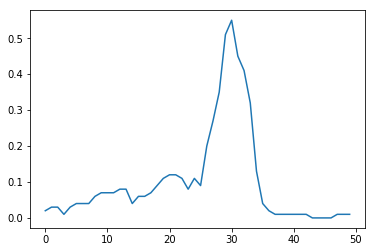

Triangular Kernel Cross-Validated Estimated Density : 


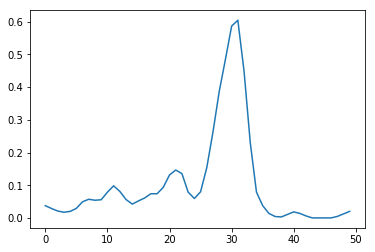

Gaussian Kernel Cross-Validated Estimated Density : 


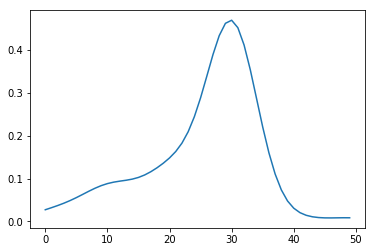

In [22]:
print("Rectangular Kernel Cross-Validated Estimated Density : ")
kernel_density_plot(X, h_opt_dict["rectangular"], "rectangular")
print("Triangular Kernel Cross-Validated Estimated Density : ")
kernel_density_plot(X, h_opt_dict["triangular"], "triangular")
print("Gaussian Kernel Cross-Validated Estimated Density : ")
kernel_density_plot(X, h_opt_dict["gaussian"], "gaussian")

$$\underline{\text{Exercice 2 : Données réelles}} $$

Nous utiliserons le data set du Titanic.
$$$$
Celui-ci est une base regroupant des informations sur les personnes à bord du bateau, en présentant diverses caractéristiques, notamment si les individus ont survécu au célebre nauvrage.

Nous décisons d'estimer la densité de probabilité de l'age des passagers du Titanic, nous permettant ainsi de répondre à des questions du type:
    - Quelle est la probabilité qu'un passager du titanic ait moins de 5 ans ? 
    - Quelle est la probabilité qu'un passager du titanic ait entre 17 et 47 ans ?
    - etc

On lit le fichier de données, puis on sélectionne la variable d'interêt (l'age).
$$$$
Enfin, on affiche l'histogramme de cette variable

Histogram of the age of Titanic's passengers : 


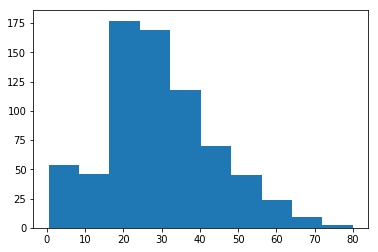

In [21]:
print("Histogram of the age of Titanic's passengers : ")
file_path = "train.xlsx"
df = pd.read_excel(file_path)
X = df["Age"].dropna()
plt.hist(X)
plt.show()

On estime puis on affiche la densité estimé, avec les 3 noyaux utilisées (Gaussien, Triangulaire, Gaussien)
$$$$
Les différentes fenêtres de lissage utilisées ont été estimées graphiquement, à l'oeil.

Rectangular Kernel Estimated Density : 


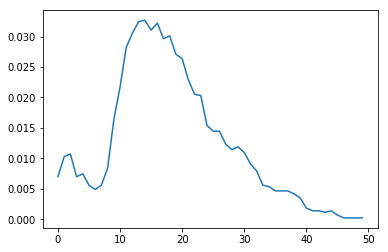

Triangular Kernel Estimated Density : 


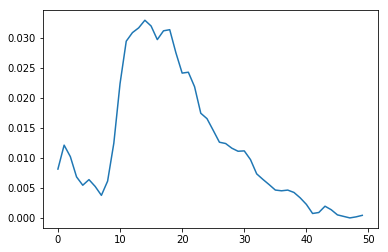

Gaussian Kernel Estimated Density : 


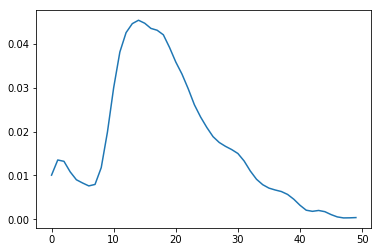

In [24]:
print("Rectangular Kernel Estimated Density : ")
kernel_density_plot(X, 3, "rectangular")
print("Triangular Kernel Estimated Density : ")
kernel_density_plot(X, 3, "triangular")
print("Gaussian Kernel Estimated Density : ")
kernel_density_plot(X, 1.5, "gaussian")

On estime la fenêtre de lissage optimale, pour chaque noyau, par la méthode de validation croisée

In [ ]:
h_opt_dict = h_opt(X)

On affiche ensuite les estimateurs par validation croisée pour chaque noyau

In [ ]:
print("Rectangular Cross-validated Kernel-Estimated Density of 'Real Data' Dataset : ")
print(" --> cross-validated smooting paramater (h) : " + str(h_opt_dict["rectangular"]))
kernel_density_plot(X, h_opt_dict["rectangular"], "rectangular")
print("Traingular Cross-validated Kernel-Estimated Density of 'Real Data' Dataset : ")
print(" --> cross-validated smooting paramater (h) : " + str(h_opt_dict["triangular"]))
kernel_density_plot(X, h_opt_dict["triangular"], "triangular")
print("Gaussian Cross-validated Kernel-Estimated Density of 'Real Data' Dataset : ")
print(" --> cross-validated smooting paramater (h) : " + str(h_opt_dict["gaussian"]))
kernel_density_plot(X, h_opt_dict["gaussian"], "gaussian")